In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#seaborn 'colorblind' palette
c1,c3,c2,_,_,_,_ = clrs = mpl.rcParams['axes.color_cycle'] = \
[(0.0, 0.4470588235294118, 0.6980392156862745),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 array((106,65,47))/255.] #muted brown, not originally part of 'colorblind'

In [3]:
import cPickle as pickle
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter
import os.path as osp
import cosmoslik as K
from glob import glob
import tarfile
from scipy.special import erfinv
from itertools import chain

In [4]:
rl=dict(pickle.load(open("dat/result_real")))

In [5]:
# sims={}
# for f in glob('dat/ch/*/*'):
#     tf = tarfile.open(f)
#     try:
#         sim = pickle.load(tf.extractfile((x for x in tf.getnames() if 'lslice' in x).next()))
#         for ((seed,lslice),dat) in sim:
#             s=sims[seed]=sims.get(seed,{})
#             s[lslice]=dat
#     except Exception as e:
#         print f

# for f in glob('dat/oldsim/*'):
#     sim = pickle.loads(open(f).read().replace('Result','OptimizeResult'))
#     for (lslice,dat) in sim:
#         s=sims[dat['seed']]=sims.get(dat['seed'],{})
#         s[lslice]=dat

# pickle.dump(sims,open('dat/ch/ch.pkl','w'),protocol=2)

sims=pickle.load(open('dat/ch/ch.pkl'))

In [55]:
lslice1 = (2,800)
lslice2 = (2,2509)
goodsims = {k:s for k,s in sims.items() if lslice1 in s and lslice2 in s}
ps = [k for k in goodsims.values()[0].values()[0] if k.startswith('cosmo') and '8' not in k]
shifts = K.chains.Chain({k:array([s[lslice1][k] - s[lslice2][k] for s in goodsims.values()]) for k in ps})
for k in shifts.params(): shifts[k]-=shifts.mean(k)
shifts_real={k:(rl[lslice1][k] - rl[lslice2][k]) for k in ps}

for s in [shifts,shifts_real]: s['cosmo.100ombh2']=100*s['cosmo.ombh2']

In [7]:
# goodsims = {k:v for k,v in goodsims.items() if k>500}

In [56]:
latex = dict([('cosmo.H0',r'$H_0$'),
          ('cosmo.ommh2',r'$\omega_m$'),          
          ('cosmo.ombh2',r'$\omega_b$'),
          ('cosmo.100ombh2',r'$100\omega_b$'),              
          ('cosmo.logA',r'$\log A$'),
          ('cosmo.ns',r'$n_s$'),
          ('cosmo.tau',r'$\tau$'),
          ('cosmo.theta',r'$\theta$'),
          ('s8omm1/4',r'$\sigma_8 \Omega_m^{0.25}$'),
          ('cosmo.clamp',r'$A_s e^{-2\tau}$'),
          ('calPlanck','$y_p$'),
         ])

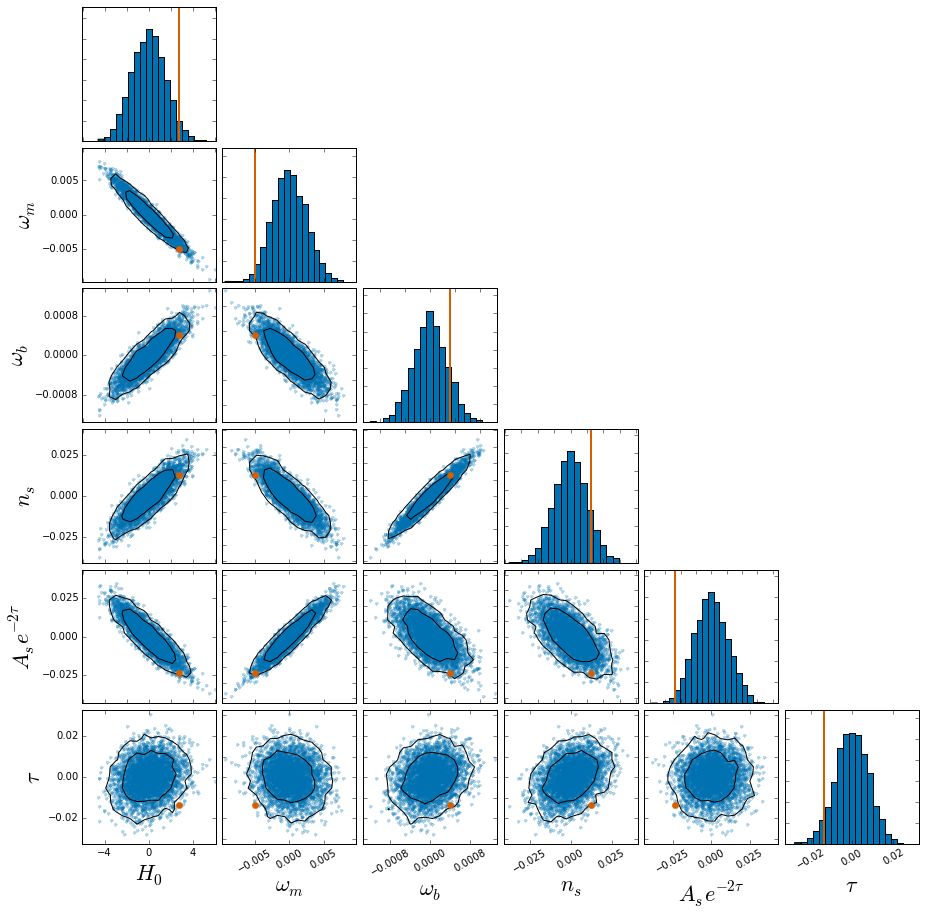

In [66]:
fig=figure(figsize=(5*3,5*3))
fig.subplots_adjust(hspace=0.05,wspace=0.05)

params = ['cosmo.H0',
          'cosmo.ommh2',
          'cosmo.ombh2',
          'cosmo.ns',
          'cosmo.clamp',
          'cosmo.tau']

for i,p1 in enumerate(params):
    for j,p2 in enumerate(params):
        if i>=j:
            ax=subplot(6,6,6*i+j+1)
            xlim(shifts.std(p2)*array([-4,4]))
            if i==j:
                h=hist(shifts[p1],bins=20)[0]
                ylim(0,h.max()*1.2)
                plot([shifts_real[p1]]*2,[0,h.max()*1.2],c=c2,lw=2)
            else:
                ylim(shifts.std(p1)*array([-4,4]))
                plot(shifts[p2],shifts[p1],marker='.',ls='',alpha=0.3,rasterized=True,zorder=-1)
                shifts.like2d(p2,p1,color='k',filled=False,nbins=17)
                plot(shifts_real[p2],shifts_real[p1],marker='.',c=c2,markersize=13)
            
            if j==0 and i!=0: 
                ax.yaxis.set_major_locator(MaxNLocator(4))
                ylabel(latex[p1],size=22)
            else: ax.set_yticklabels([])
                
            if i==5: 
                ax.xaxis.set_major_locator(MaxNLocator(4))
                xlabel(latex[p2],size=22)
                if j!=0: xticks(rotation=30)
            else: ax.set_xticklabels([])
                
savefig('/plots/sims_cloud.pdf',bbox_inches='tight')

In [10]:
params = ['cosmo.theta',
          'cosmo.omch2',
          'cosmo.ombh2',
          'cosmo.ns',
          'cosmo.clamp',
          'cosmo.tau'
         ]

cv=shifts.cov(params)
icv=inv(cv)
stds=shifts.std(params)

def stat_chi2(s,_icv=None): 
    x=[s[k] for k in params]
    return dot(x,dot(icv if _icv is None else _icv,x))

def stat_max_param(s,_icv=None):
    if _icv is not None: _stds=sqrt(diag(inv(icv)))
    else: _stds=None
    return abs([s[k] for k in params]/(stds if _stds is None else _stds)).max()

def stat_max_any(s):
    x=[s[k] for k in params]
    return sqrt(dot(x,dot(icv,x)))

In [11]:
def mkstatplot(stat,range=None):
    dist=array([stat(s) for s in shifts.iterrows()])
    r=stat(shifts_real)
    h=hist(dist,range=range,bins=25,normed=False)[0];
    plot([r]*2,[0,1.2*h.max()],lw=2,c=c2)
    ylim(0,1.2*h.max())
    
    pte=sum(dist>r)/float(dist.size)
    nsig=sqrt(2)*erfinv(1-pte)
    print pte, nsig

0.164894996111 1.38879532876


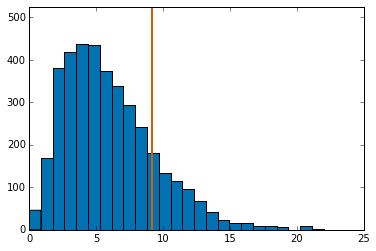

In [12]:
mkstatplot(stat_chi2,range=(0,22))

0.105003889033 1.621064115


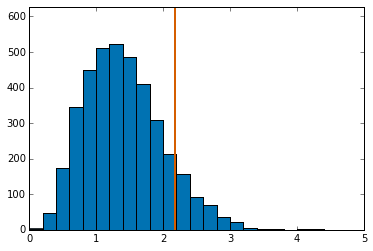

In [13]:
mkstatplot(stat_max_param,range=(0,5))

In [42]:
def mkscanplot(lsplits,lslices,stat=stat_chi2,
               leg=True, xlbl=True, ylbl=True):
    allsplits=set(chain(*lslices))
    fullsims={k:v for k,v in sims.items() if all([s in v for s in allsplits])}
    
    shifts_scan = {}
    shifts_scan_real = {}
    for lsplit,(lslice1,lslice2) in zip(lsplits,lslices):
        s = shifts_scan[lsplit] = K.chains.Chain({k:array([s[lslice1][k] - s[lslice2][k] for s in fullsims.values()]) for k in ps})
        for k in s.params(): s[k]-=s.mean(k)
        shifts_scan_real[lsplit]={k:(rl[lslice1][k] - rl[lslice2][k]) for k in ps}
        
    icvs = {lsplit:inv(shifts_scan[lsplit].cov(params)) for lsplit in lsplits}        
    
    stats={lsplit:stat(shifts_scan_real[lsplit],_icv=icvs[lsplit]) for lsplit in lsplits}
    stats_sim={lsplit:array([stat(s,_icv=icvs[lsplit]) for s in shifts_scan[lsplit].iterrows()]) for lsplit in lsplits}
    
    def dist2nsig(dist):
        pte=sum(dist)/float(dist.size)
        return sqrt(2)*erfinv(1-pte)

    nsig_local={lsplit:dist2nsig(stats_sim[lsplit]>stats[lsplit]) for lsplit in lsplits}
    dist=array([stats_sim[lsplit] for lsplit in lsplits]).max(axis=0)
    nsig_global={lsplit:dist2nsig(dist>stats[lsplit]) for lsplit in lsplits}
    
    
    plot(*transpose(sorted(nsig_local.items())),lw=1.5,marker='.',markersize=6)
    plot(*transpose(sorted(nsig_global.items())),c=c2,lw=1.5,marker='.',markersize=6)
    if leg: legend(['Local','Global'])
    if ylbl: ylabel(r'$\sigma$',size=22)
    if xlbl: xlabel(r'$\ell_{\rm split}$',size=22)
    xticks(range(500,2501,500))
    yticks(range(4))
    xlim(400,2600)
    ylim(0,3.5)
    gca().xaxis.set_minor_locator(AutoMinorLocator(5))
    gca().yaxis.set_minor_locator(AutoMinorLocator(4))    
    gca().tick_params(axis='both', which='major', labelsize=14)

    return stats,stats_sim

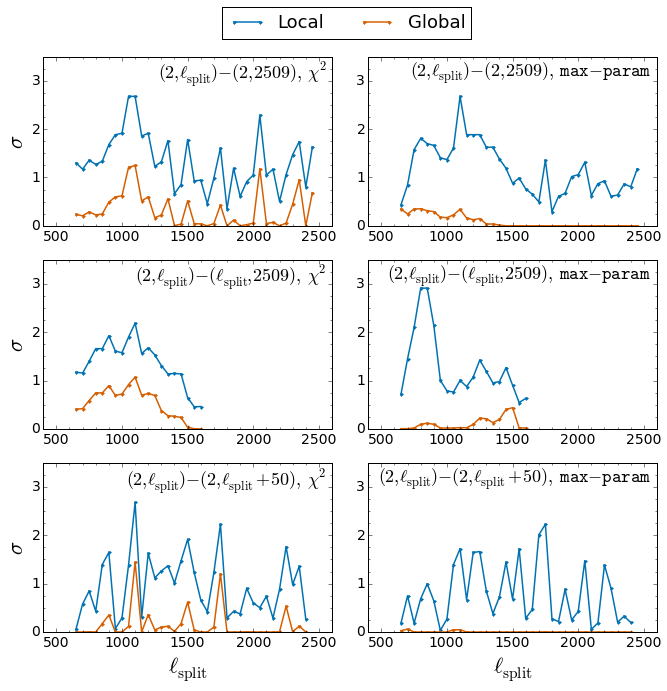

In [46]:
fig=figure(figsize=(2*5.5,3*5.5/1.6))
fig.subplots_adjust(hspace=0.2,wspace=0.2/1.6)

dat = [(range(650,2500,50), [((2,lsplit),(2,2509))      for lsplit in range(650,2500,50)], '(2,l)-(2,2509)'), 
       (range(650,1650,50), [((2,lsplit),(lsplit,2509)) for lsplit in range(650,1650,50)], '(2,l)-(l,2509)'), 
       (range(650,2450,50), [((2,lsplit),(2,lsplit+50)) for lsplit in range(650,2450,50)], '(2,l)-(2,l+50)'),
      ]

for i,(lsplits,lslices,lbl) in enumerate(dat):
    lbl=lbl.replace('l',r'\ell_{\rm split}')
    
    ax=subplot(3,2,2*i+1)
    mkscanplot(lsplits,lslices,stat=stat_chi2,leg=False,xlbl=(i==2))
    if i==0: legend(['Local','Global'],ncol=3, loc='lower center', bbox_to_anchor=(1.05, 1.05),prop={'size':18})
    text(0.98,0.98,r'$%s,\,{\rm \chi^2}$'%lbl,size=18,  
         horizontalalignment='right',verticalalignment='top',transform=ax.transAxes)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax=subplot(3,2,2*i+2)
    mkscanplot(lsplits,lslices,stat=stat_max_param,ylbl=False,leg=False,xlbl=(i==2))
    text(0.98,0.98,r'$%s,\,{\rm \mathtt{max-param}}$'%lbl,size=18,
         horizontalalignment='right',verticalalignment='top',transform=ax.transAxes)
    ax.tick_params(axis='both', which='major', labelsize=14)

savefig('/plots/stats_lsplit_scan.pdf',bbox_inches='tight')